In [1]:
import torch
import numpy as np
from tqdm import tqdm, trange
import matplotlib.pyplot as plt
from sklearn.metrics import recall_score
from experiments import constants
from experiments import misc_utils
from influence_utils import faiss_utils

faiss_index = faiss_utils.FAISSIndex(768, "Flat")
faiss_index.load(constants.MNLI_FAISS_INDEX_PATH)
full_influences_collections = torch.load("/export/home/Experiments/20200818/MNLI-influences-full.pt")

len(faiss_index)

wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.


392702

In [2]:
tokenizer, model = misc_utils.create_tokenizer_and_model(
    constants.MNLI_MODEL_PATH)

(mnli_train_dataset,
 mnli_eval_dataset) = misc_utils.create_datasets(
    task_name="mnli",
    tokenizer=tokenizer)

eval_instance_data_loader = misc_utils.get_dataloader(
    dataset=mnli_eval_dataset,
    batch_size=1,
    random=False)

Params Trainable: 14768643
	bert.encoder.layer.10.attention.self.query.weight
	bert.encoder.layer.10.attention.self.query.bias
	bert.encoder.layer.10.attention.self.key.weight
	bert.encoder.layer.10.attention.self.key.bias
	bert.encoder.layer.10.attention.self.value.weight
	bert.encoder.layer.10.attention.self.value.bias
	bert.encoder.layer.10.attention.output.dense.weight
	bert.encoder.layer.10.attention.output.dense.bias
	bert.encoder.layer.10.attention.output.LayerNorm.weight
	bert.encoder.layer.10.attention.output.LayerNorm.bias
	bert.encoder.layer.10.intermediate.dense.weight
	bert.encoder.layer.10.intermediate.dense.bias
	bert.encoder.layer.10.output.dense.weight
	bert.encoder.layer.10.output.dense.bias
	bert.encoder.layer.10.output.LayerNorm.weight
	bert.encoder.layer.10.output.LayerNorm.bias
	bert.encoder.layer.11.attention.self.query.weight
	bert.encoder.layer.11.attention.self.query.bias
	bert.encoder.layer.11.attention.self.key.weight
	bert.encoder.layer.11.attention.self.ke

100%|██████████| 3/3 [00:07<00:00,  2.50s/it]


CPU times: user 6min 46s, sys: 472 ms, total: 6min 46s
Wall time: 5min 1s


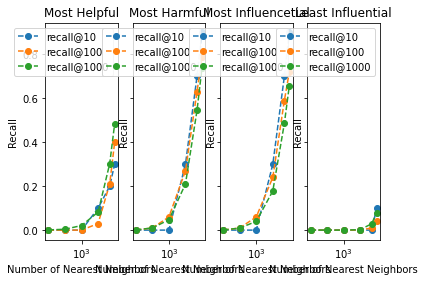

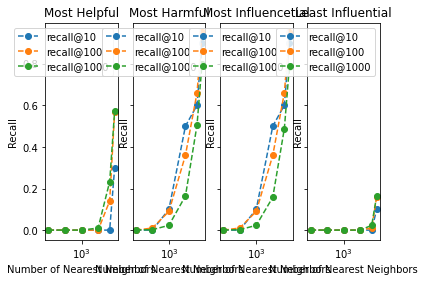

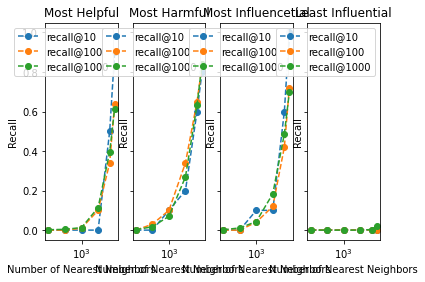

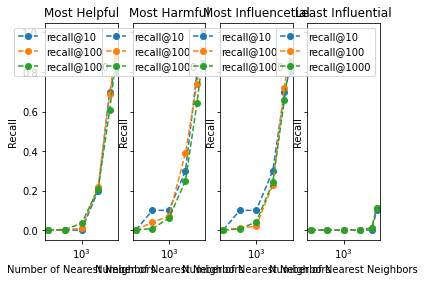

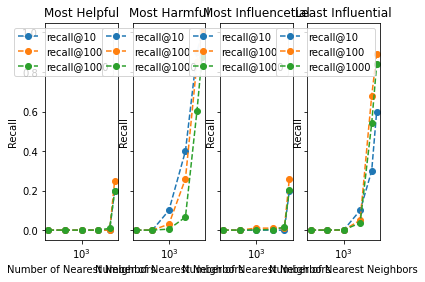

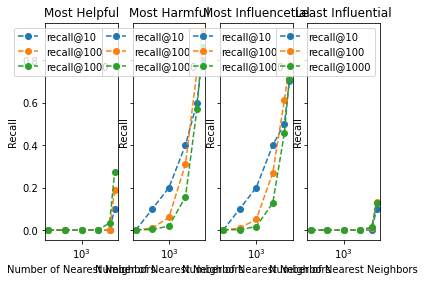

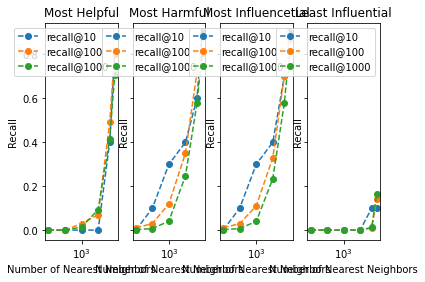

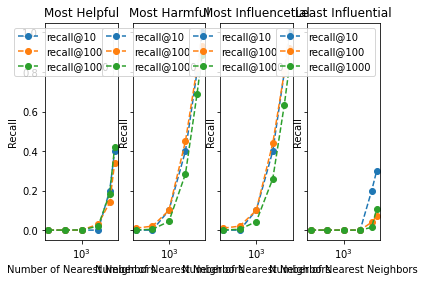

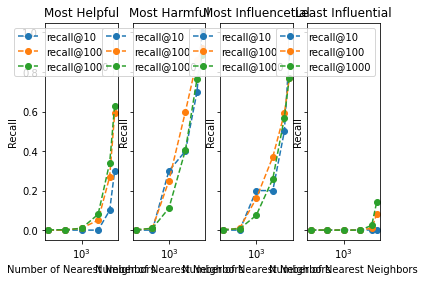

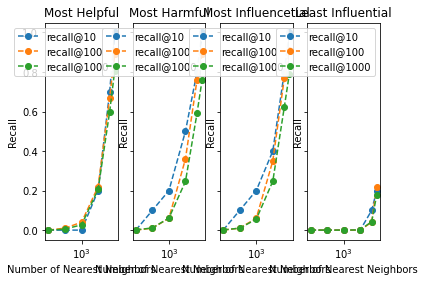

In [4]:
%%time
recalls_collections = []
for i, example in enumerate(eval_instance_data_loader):
    if i >= len(full_influences_collections):
        break
    full_influences_dict = full_influences_collections[i]["influences"]
    recalls_collection = get_recall_plot(model, example, faiss_index, full_influences_dict)
    recalls_collections.append(recalls_collection)

In [3]:
def get_recall_plot(model, example, faiss_index, full_influences_dict):
    # plt.rcParams["figure.figsize"] = [20, 5]
    recall_num_neighbors = [10, 100, 1000]
    num_neighbors = [10, 100, 1000, 10000, 50000, 100000]
    names = ["Most Helpful",
             "Most Harmful",
             "Most Influencetial",
             "Least Influential"]

    features = misc_utils.compute_BERT_CLS_feature(model, **example)
    features = features.cpu().detach().numpy()
    if list(full_influences_dict.keys()) != list(range(len(full_influences_dict))):
        raise ValueError

    full_influences = []
    for key in sorted(full_influences_dict):
        full_influences.append(full_influences_dict[key])

    sorted_indices_small_to_large = np.argsort(full_influences)
    sorted_indices_large_to_small = np.argsort(full_influences)[::-1]
    sorted_indices_abs_large_to_small = np.argsort(np.abs(full_influences))[::-1]
    sorted_indices_abs_small_to_large = np.argsort(np.abs(full_influences))

    fig, axes = plt.subplots(1, 4, sharex=True, sharey=True)
    recalls_collections = {}
    for i, (name, sorted_indices) in enumerate(zip(
            names,
            [sorted_indices_small_to_large,
             sorted_indices_large_to_small,
             sorted_indices_abs_large_to_small,
             sorted_indices_abs_small_to_large])):

        recalls_collection = []
        for recall_k in tqdm(recall_num_neighbors):
            recalls = []
            influential = sorted_indices[:recall_k]
            influential_set = set(influential.tolist())
            for k in num_neighbors:
                distances, indices = faiss_index.search(k=k, queries=features)
                indices_set = set(indices.squeeze(axis=0).tolist())
                recall = len(influential_set & indices_set) / len(influential_set)
                recalls.append(recall)

            recalls_collection.append(recalls)
            axes[i].plot(num_neighbors, recalls,
                         linestyle="--", marker="o",
                         label=f"recall@{recall_k}")

        axes[i].legend()
        axes[i].set_title(name)
        axes[i].set_xscale("log")
        axes[i].set_ylabel("Recall")
        axes[i].set_xlabel("Number of Nearest Neighbors")
        recalls_collections[name] = recalls_collection

    return recalls_collections


In [11]:
recalls_collections[0].keys()

dict_keys(['Most Helpful', 'Most Harmful', 'Most Influencetial', 'Least Influential'])

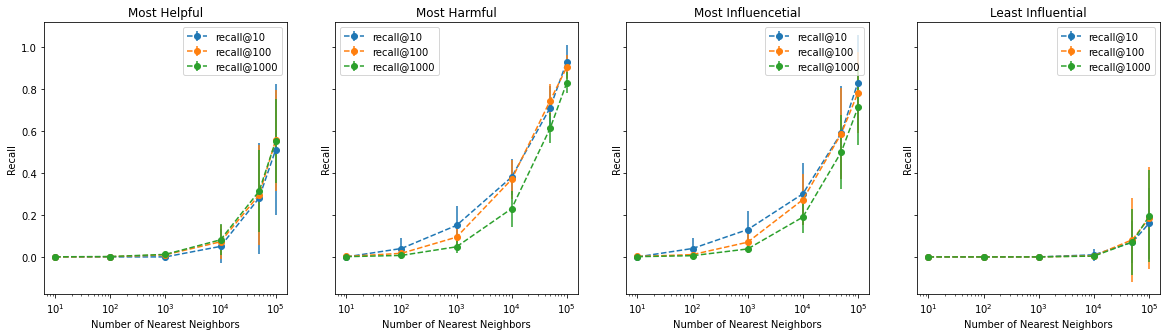

In [18]:
plt.rcParams["figure.figsize"] = [20, 5]
recall_num_neighbors = [10, 100, 1000]
num_neighbors = [10, 100, 1000, 10000, 50000, 100000]
fig, axes = plt.subplots(1, 4, sharex=True, sharey=True)
for name_index, name in enumerate(recalls_collections[0].keys()):
    for k_index, recall_k in enumerate(recall_num_neighbors):
        recalls_stacked = np.stack([recalls[name][k_index] for recalls in recalls_collections], axis=0)
        recalls_mean = recalls_stacked.mean(axis=0)
        recalls_std = recalls_stacked.std(axis=0)
        axes[name_index].errorbar(num_neighbors, recalls_mean, yerr=recalls_std,
                     linestyle="--", marker="o",
                     label=f"recall@{recall_k}")

    axes[name_index].legend()
    axes[name_index].set_title(name)
    axes[name_index].set_xscale("log")
    axes[name_index].set_ylabel("Recall")
    axes[name_index].set_xlabel("Number of Nearest Neighbors")

In [19]:
fig.savefig("./20200819-knn-recalls.pdf")